<a href="https://colab.research.google.com/github/aghosh92/DKLActiveLearnMol/blob/main/Notebooks/notebookI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we explore the latent space generated by a traditional variational autoencoder (VAE) for molecules. The VAEs build latent spaces based on the data only.


- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The GPax and pyroVED are by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- Workflow built by Sergei V. Kalinin
- VAE for subsets of QM9 dataset adapted by Ayana Ghosh

In [1]:
# @title Install packages
!pip install wget
!pip install rdkit-pypi
!pip install selfies --upgrade
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai
!pip install -q git+https://github.com/ziatdinovmax/pyroVED@main #pyroVED for VAE

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f186ab287f85bd7f9239b4320ed9864c6090ecfe92ef61a86fa87256f1bc94d4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 37.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi
import pyroved as pv

import jax.numpy as jnp
gpax.utils.enable_x64()

In [3]:
# @title Utility functions
def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point], embedding, 'euclidean').flatten()
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]  # Exclude the reference point itself
    return nearest_indices

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

Read in dataset (One of the subsets from QM9 containing 5,000 randomly selected molecules)

In [4]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,OCC(C#C)C#CC#C,-0.13530,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,1,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,OC1C2NC1(C#C)C2O,-1.93440,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,0,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,C1C2C3CC(CCO3)N12,0.23180,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,0,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,CC1=CC2CC(O2)C1O,0.46470,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,0,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,CC1CC1(O)CCC=O,0.73640,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,3,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117107,OC1C2C3NC3(C#N)C12,-1.15892,65.96,122.048013,2,3,"(46,)",0.128183,-0.392345,0,...,5,6.3772,-416.738039,-416.738983,-416.746403,-416.778259,-0.2729,0.0142,0.2871,0.113488
8240,NC(=O)C(=O)NCC=O,-2.21320,89.26,130.037842,2,3,"(50,)",0.308947,-0.361393,2,...,0,2.7234,-491.145917,-491.146862,-491.156301,-491.192146,-0.2543,-0.0462,0.2081,0.111181
82724,CC1C(C)N1CC1CO1,0.47780,15.54,127.099714,0,2,"(52,)",0.093621,-0.371734,2,...,3,2.2996,-404.281755,-404.282699,-404.292728,-404.328359,-0.2208,0.0761,0.2969,0.192277
33180,NC(=O)C1CC1CCO,-0.50980,63.32,129.078979,2,2,"(52,)",0.220321,-0.396365,3,...,2,3.7023,-440.294320,-440.295265,-440.305434,-440.341331,-0.2486,0.0246,0.2732,0.170268


Convert smiles to one-hot vectors

In [5]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(5000, 567)


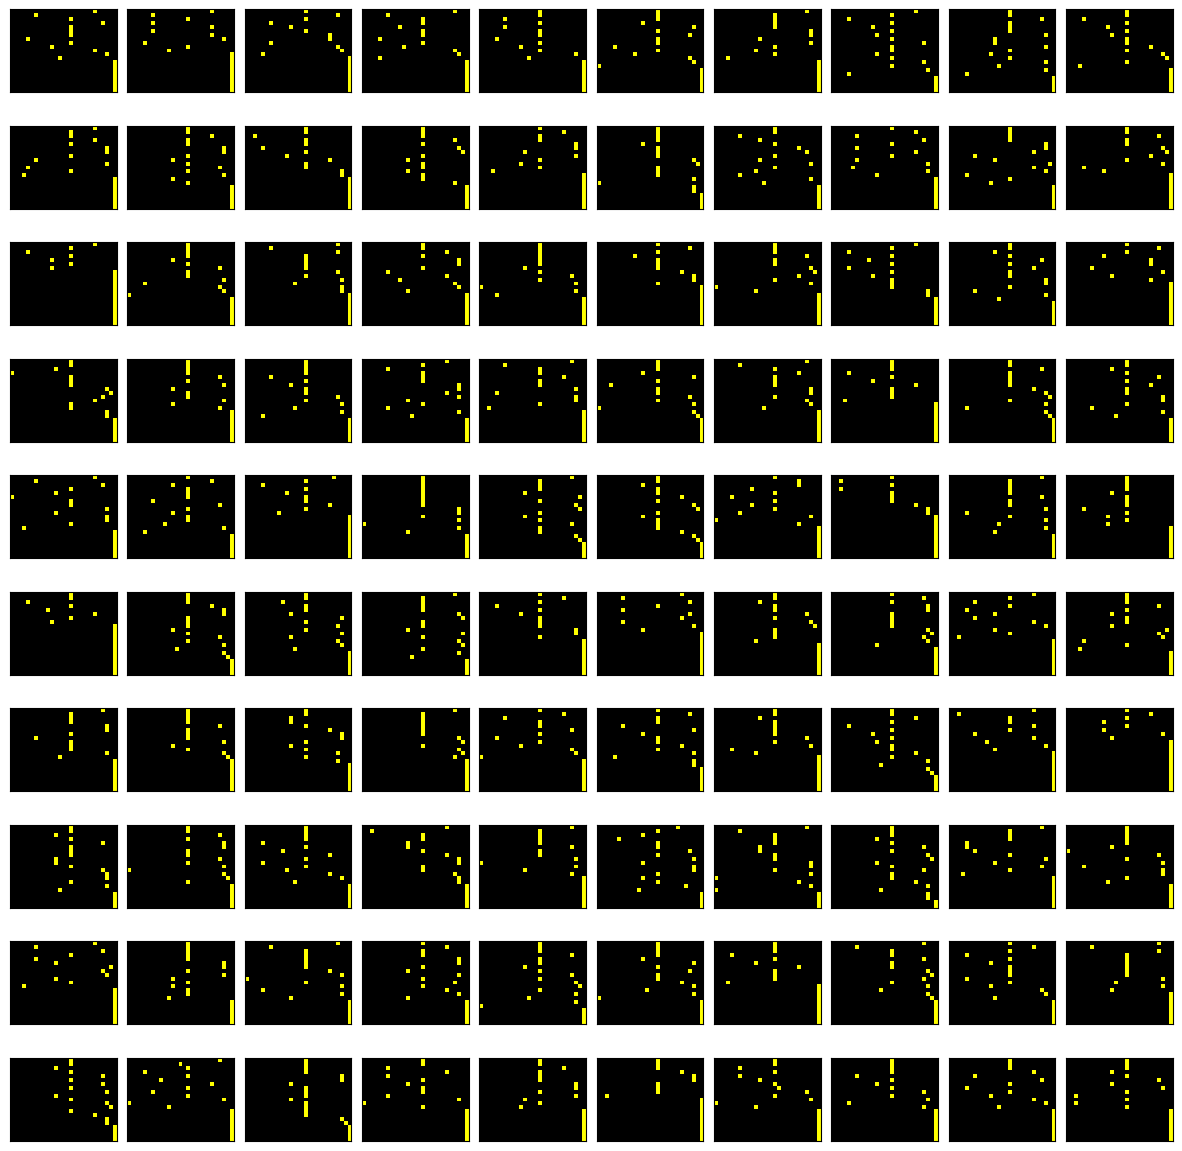

In [ ]:
# Plotting few one-hot vectors
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(molecules))
    ax.imshow(molecules[i], cmap='gnuplot', interpolation = None)

Train a traditional VAE using AtomAI implementation

In [ ]:
input_dim = (molecules.shape[1], molecules.shape[2])

vae = aoi.models.VAE(input_dim, latent_dim=2,
                    numlayers_encoder=3, numhidden_encoder=128,
                    numlayers_decoder=3, numhidden_decoder=128,
                    skip=True)

vae.fit(molecules, training_cycles=300, batch_size=75, loss="ce", filename='vae')

Epoch: 1/300, Training loss: 352.2415
Epoch: 2/300, Training loss: 172.8035
Epoch: 3/300, Training loss: 88.7060
Epoch: 4/300, Training loss: 67.4083
Epoch: 5/300, Training loss: 58.3799
Epoch: 6/300, Training loss: 53.4900
Epoch: 7/300, Training loss: 50.4504
Epoch: 8/300, Training loss: 48.3737
Epoch: 9/300, Training loss: 46.9458
Epoch: 10/300, Training loss: 45.9081
Epoch: 11/300, Training loss: 45.0039
Epoch: 12/300, Training loss: 44.3715
Epoch: 13/300, Training loss: 43.8585
Epoch: 14/300, Training loss: 43.3557
Epoch: 15/300, Training loss: 43.0296
Epoch: 16/300, Training loss: 42.6990
Epoch: 17/300, Training loss: 42.4191
Epoch: 18/300, Training loss: 42.1694
Epoch: 19/300, Training loss: 42.0119
Epoch: 20/300, Training loss: 41.8157
Epoch: 21/300, Training loss: 41.6268
Epoch: 22/300, Training loss: 41.5377
Epoch: 23/300, Training loss: 41.3806
Epoch: 24/300, Training loss: 41.2767
Epoch: 25/300, Training loss: 41.1894
Epoch: 26/300, Training loss: 41.1105
Epoch: 27/300, Trai

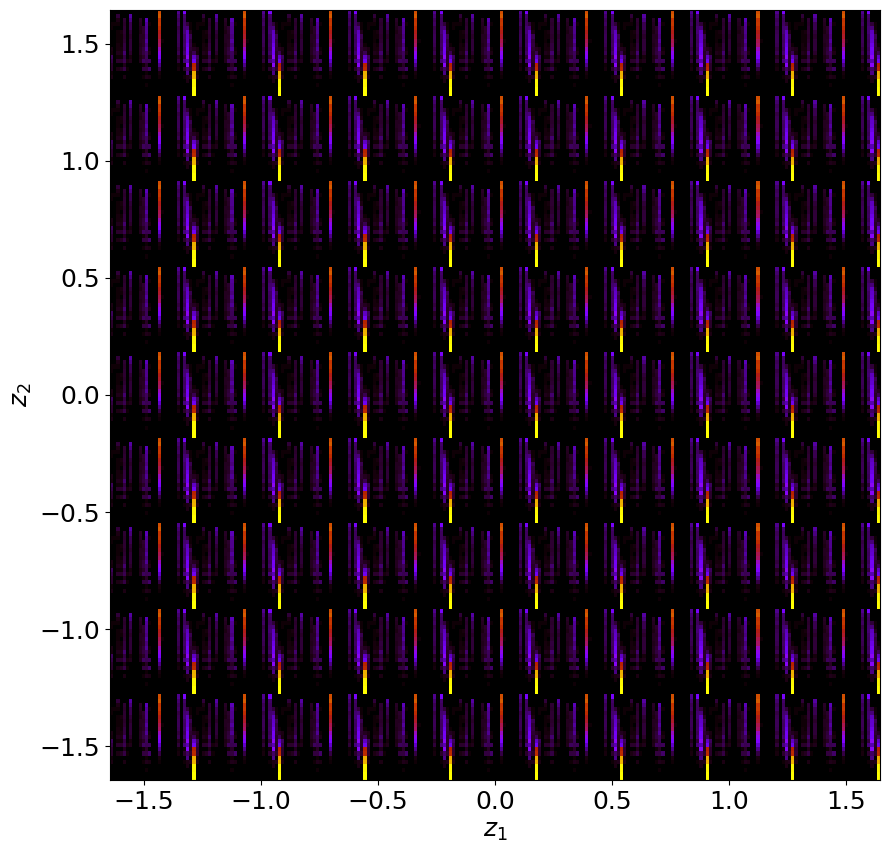

In [ ]:
# Latent representation
vae.manifold2d(d = 9, origin = 'upper');

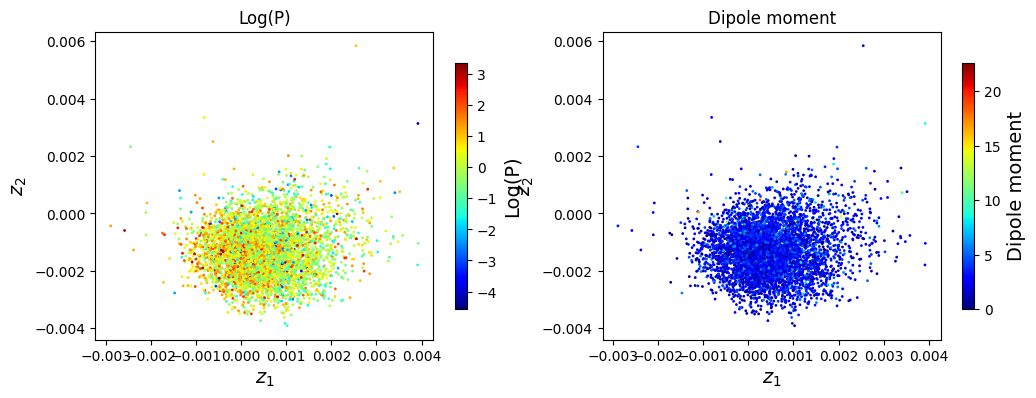

In [ ]:
# Latent distributions

z_mean, z_sd = vae.encode(molecules)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=df['mole_logp'], s=1, cmap='jet')
ax[0].set_title('Log(P)')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=df['dipole_moment'], s=1, cmap='jet')
ax[1].set_title('Dipole moment')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Dipole moment", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## VAE PyroVED

In [6]:
in_dim = (molecules.shape[1], molecules.shape[2])
train_data = torch.tensor(molecules).float()

In [7]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data, batch_size=75)

vae = pv.models.iVAE(in_dim, latent_dim=2,
                    hidden_dim_e = [64, 64], # corresponds to the number of neurons in the hidden layers of the encoder
                    hidden_dim_d = [64, 64],  # corresponds to the number of neurons in the hidden layers of the decoder
                    activation='relu',
                    invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
# beta here is the coefficient of the KLD term.
# It can be constant or a function of iteration number
for e in range(300):
    trainer.step(train_loader, scale_factor = 1)
    trainer.print_statistics()

Epoch: 1 Training loss: 191.5308
Epoch: 2 Training loss: 46.9221
Epoch: 3 Training loss: 44.1751
Epoch: 4 Training loss: 43.2803
Epoch: 5 Training loss: 42.8338
Epoch: 6 Training loss: 42.5278
Epoch: 7 Training loss: 42.2897
Epoch: 8 Training loss: 42.0901
Epoch: 9 Training loss: 41.8336
Epoch: 10 Training loss: 41.5124
Epoch: 11 Training loss: 41.0279
Epoch: 12 Training loss: 40.4855
Epoch: 13 Training loss: 39.5469
Epoch: 14 Training loss: 38.4932
Epoch: 15 Training loss: 37.9552
Epoch: 16 Training loss: 37.6264
Epoch: 17 Training loss: 37.4400
Epoch: 18 Training loss: 37.2893
Epoch: 19 Training loss: 37.1224
Epoch: 20 Training loss: 37.0212
Epoch: 21 Training loss: 36.9332
Epoch: 22 Training loss: 36.8439
Epoch: 23 Training loss: 36.7948
Epoch: 24 Training loss: 36.7116
Epoch: 25 Training loss: 36.6729
Epoch: 26 Training loss: 36.6233
Epoch: 27 Training loss: 36.5957
Epoch: 28 Training loss: 36.5412
Epoch: 29 Training loss: 36.5203
Epoch: 30 Training loss: 36.4813
Epoch: 31 Training

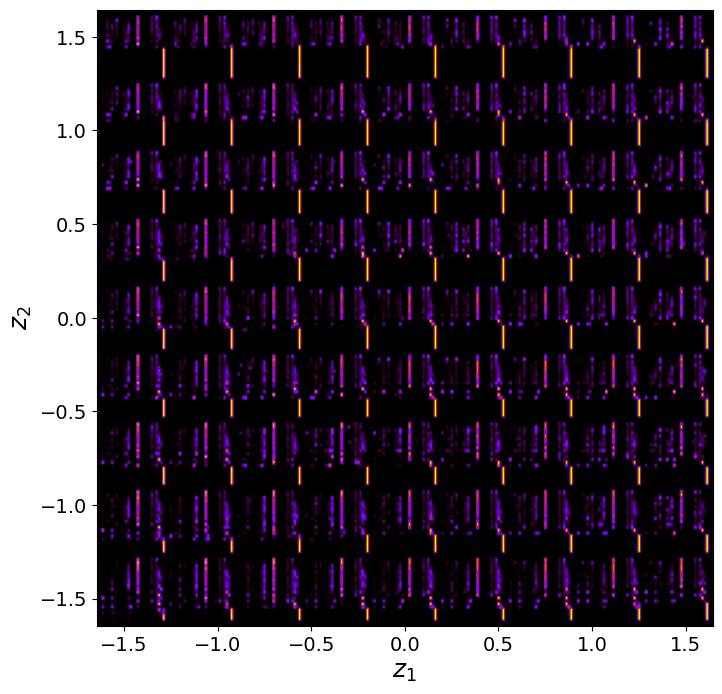

In [8]:
# Latent representation
vae.manifold2d(d = 9, origin = 'upper');

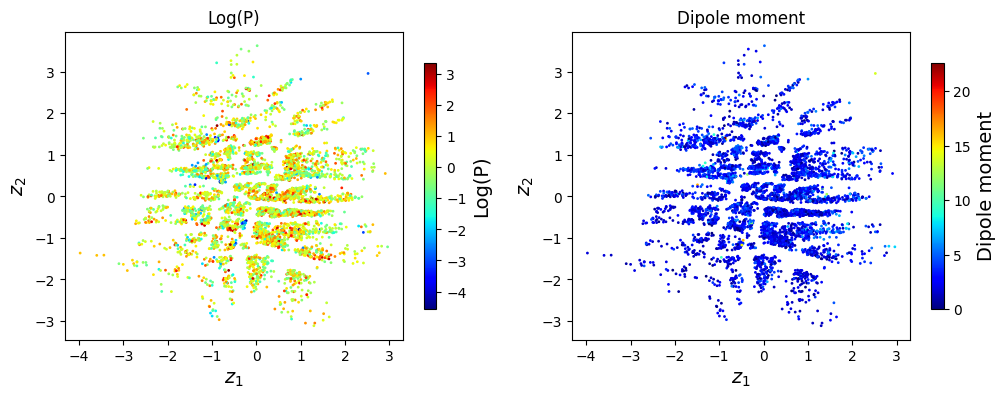

In [9]:
# Latent distributions

z_mean, z_sd = vae.encode(train_data)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=df['mole_logp'], s=1, cmap='jet')
ax[0].set_title('Log(P)')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=df['dipole_moment'], s=1, cmap='jet')
ax[1].set_title('Dipole moment')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Dipole moment", fontsize=14)
cbar.ax.tick_params(labelsize=10)